# Hamiltonian Monte Carlo estimates of RLCT

We train a small neural network to "convergence" at a weight vector `w_0` and then initialise Hamiltonian Monte Carlo (HMC) estimation of the posterior with a chain starting at `w_0`. We run this HMC with some step size adaptation, and wait for it to "plateau" in the sense that the acceptance rate becomes high (which we interpret as the chain finding something like a local minima, from which it is difficult to escape at the final step size). Let `w_1` be this weight vector at which the HMC chain is temporarily stationary. We then restart HMC at a smaller step size, but with a modified log probability distribution which prevents the chain from exiting an epsilon ball around `w_1`.

Finally we sample from this probability distribution on the epsilon ball around `w_1` to generate an estimate of the local Real Log Canonical Threshold (RLCT) of the neural network around `w_1`.

This code is heavily based on notebooks found here:
https://colab.research.google.com/drive/1bWQcuR5gaBPpow6ARKnPPL-dtf2EvTae#scrollTo=zNhVpzE95IGp
https://github.com/tensorflow/probability/issues/292

In [1]:
# Installation
#%%bash
#cd /tmp
#wget https://github.com/tensorflow/probability/files/3103693/data.zip
#unzip data.zip

# 1. Setup

In [2]:
from __future__ import print_function

import math
from datetime import datetime
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn.preprocessing
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

tf.enable_v2_behavior()

In [3]:
def dense(X, W, b, activation):
    return activation(tf.matmul(X, W) + b)

def build_network(weights_list, biases_list, activation=tf.nn.relu):
    def model(X):
        net = X
        for (weights, biases) in zip(weights_list[:-1], biases_list[:-1]):
            net = dense(net, weights, biases, activation)
        # final linear layer
        net = tf.matmul(net, weights_list[-1]) + biases_list[-1]
        preds = net[:, 0]
        std_devs = tf.exp(-net[:, 1])
        # preds and std_devs each have size N = X.shape(0) (the number of data samples)
        # and are the model's predictions and (log-sqrt of) learned loss attenuations, resp.
        return tfd.Normal(loc=preds, scale=std_devs)

    return model

def get_initial_state(weight_prior, bias_prior, num_features, layers=None):
    """generate starting point for creating Markov chain
        of weights and biases for fully connected NN
    Keyword Arguments:
        layers {tuple} -- number of nodes in each layer of the network
    Returns:
        list -- architecture of FCNN with weigths and bias tensors for each layer
    """
    # make sure the last layer has two nodes, so that output can be split into
    # predictive mean and learned loss attenuation (see https://arxiv.org/abs/1703.04977)
    # which the network learns individually
    if layers is not None:
        assert layers[-1] == 2
    if layers is None:
        layers = (
            num_features,
            num_features // 2,
            num_features // 5,
            num_features // 10,
            2,
        )
    else:
        layers.insert(0, num_features)

    architecture = []
    for idx in range(len(layers) - 1):
        weigths = weight_prior.sample((layers[idx], layers[idx + 1]))
        biases = bias_prior.sample((layers[idx + 1]))
        # weigths = tf.zeros((layers[idx], layers[idx + 1]))
        # biases = tf.zeros((layers[idx + 1]))
        architecture.extend((weigths, biases))
    return architecture


def bnn_joint_log_prob_fn(weight_prior, bias_prior, X, y, *args):
    weights_list = args[::2]
    biases_list = args[1::2]

    # prior log-prob
    lp = sum(
        [tf.reduce_sum(weight_prior.log_prob(weights)) for weights in weights_list]
    )
    lp += sum([tf.reduce_sum(bias_prior.log_prob(bias)) for bias in biases_list])

    # likelihood of predicted labels
    network = build_network(weights_list, biases_list)
    labels_dist = network(X.astype("float32"))
    lp += tf.reduce_sum(labels_dist.log_prob(y))
    return lp


def trace_fn(current_state, results, summary_freq=100):
    #step = results.step
    #with tf.summary.record_if(tf.equal(step % summary_freq, 0)):
    #    for idx, tensor in enumerate(current_state, 1):
    #        count = str(math.ceil(idx / 2))
    #        name = "weights_" if idx % 2 == 0 else "biases_" + count
    #        tf.summary.histogram(name, tensor, step=tf.cast(step, tf.int64))
    return results


@tf.function
def graph_hmc(*args, **kwargs):
    """Compile static graph for tfp.mcmc.sample_chain.
    Since this is bulk of the computation, using @tf.function here
    signifcantly improves performance (empirically about ~5x).
    """
    return tfp.mcmc.sample_chain(*args, **kwargs)


def nest_concat(*args):
    return tf.nest.map_structure(lambda *parts: tf.concat(parts, axis=0), *args)


def run_hmc(
    target_log_prob_fn,
    step_size=0.01,
    num_leapfrog_steps=3,
    num_burnin_steps=1000,
    num_adaptation_steps=800,
    num_results=1000,
    num_steps_between_results=0,
    current_state=None,
    logdir="/tmp/data/output/hmc/",
    resume=None,
):
    """Populates a Markov chain by performing `num_results` gradient-informed steps with a
    Hamiltonian Monte Carlo transition kernel to produce a Metropolis proposal. Either
    that or the previous state is appended to the chain at each step.

    Arguments:
        target_log_prob_fn {callable} -- Determines the HMC transition kernel
        and thereby the stationary distribution that the Markov chain will approximate.
        
    Returns:
        (chain(s), trace, final_kernel_result) -- The Markov chain(s), the trace created by `trace_fn`
        and the kernel results of the last step.
    """
    assert (current_state, resume) != (None, None)

    # Set up logging.
    stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    logdir = logdir + stamp
    summary_writer = tf.summary.create_file_writer(logdir)

    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn, step_size=step_size, num_leapfrog_steps=num_leapfrog_steps
    )
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        kernel, num_adaptation_steps=num_adaptation_steps
    )
    #kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=target_log_prob_fn, step_size=0.01, volatility_fn = lambda *args: 0.)
    if resume is None:
        prev_kernel_results = kernel.bootstrap_results(current_state)
        step = 0
    else:
        prev_chain, prev_trace, prev_kernel_results = resume
        step = len(prev_chain)
        current_state = tf.nest.map_structure(lambda chain: chain[-1], prev_chain)

    tf.summary.trace_on(graph=True, profiler=True)
    with summary_writer.as_default():
        tf.summary.trace_export(
            name="mcmc_sample_trace", step=step, profiler_outdir=logdir
        )
        chain, trace, final_kernel_results = graph_hmc(
            kernel=kernel,
            current_state=current_state,
            num_burnin_steps=num_burnin_steps,
            num_results=num_burnin_steps + num_results,
            previous_kernel_results=prev_kernel_results,
            num_steps_between_results=num_steps_between_results,
            trace_fn=partial(trace_fn, summary_freq=20),
            return_final_kernel_results=True,
        )
    summary_writer.close()

    if resume:
        chain = nest_concat(prev_chain, chain)
        trace = nest_concat(prev_trace, trace)

    return chain, trace, final_kernel_results


def get_data(test_size=0.1, random_state=0):
    with open("/tmp/features.csv") as file:
        features = np.genfromtxt(file, delimiter=",")
    with open("/tmp/labels.csv") as file:
        labels = np.genfromtxt(file, delimiter=",")

    labels = np.log(labels).reshape(-1, 1)

    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        features, labels, test_size=test_size, random_state=random_state
    )
    X_scaler = sklearn.preprocessing.StandardScaler().fit(X_train)
    y_scaler = sklearn.preprocessing.StandardScaler().fit(y_train)
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)
    y_train = y_scaler.transform(y_train)
    y_test = y_scaler.transform(y_test)

    return (X_train, X_test), (y_train, y_test), (X_scaler, y_scaler)

# See the discussion of the format of chain in "HMC from MAP" below. 
def plot_curves(chain):
  weights_list = chain[::2]
  biases_list = chain[1::2]

  train_trace = []
  test_trace = []
  for i in range(len(weights_list[0])):
    network = build_network([w[i] for w in weights_list], [b[i] for b in biases_list])(X_train.astype(np.float32))
    train_trace.append(-tf.reduce_mean(network.log_prob(y_train[:, 0])).numpy())
    network = build_network([w[i] for w in weights_list], [b[i] for b in biases_list])(X_test.astype(np.float32))
    test_trace.append(-tf.reduce_mean(network.log_prob(y_test[:, 0])).numpy())
  
  plt.plot(train_trace, label='train')
  plt.plot(test_trace, label='test')
  plt.legend(loc='best')
    
def plot_distances(chain, center):
  weights_list = chain[::2]
  biases_list = chain[1::2]

  center_weights = center[::2]
  center_biases = center[1::2]
      
  distances = []
  
  # weights_list[0] is of length the number of samples in the Markov chain
  for i in range(len(weights_list[0])):
    d = 0.0
    
    for (w,wprime) in zip(weights_list,center_weights):
      d += tf.square(tf.norm(w[i] - wprime))
    
    for (b,bprime) in zip(biases_list,center_biases):
      d += tf.square(tf.norm(b[i] - bprime))
    
    d = tf.sqrt(d)

    distances.append(d)
  
  #print(np.mean(distances))
  plt.plot(distances)

# 2. Train the neural network

The final network weights are `map_initial_state`.
### 2.1 Setup priors and data

In [4]:
# Setup priors and data
weight_prior = tfd.Normal(0.0, 0.1)
bias_prior = tfd.Normal(0.0, 1.0)
(X_train, X_test), (y_train, y_test), scalers = get_data()

bnn_joint_log_prob = partial(
    bnn_joint_log_prob_fn, weight_prior, bias_prior, X_train, y_train[:, 0]
)
num_features = X_train.shape[1]
initial_state = get_initial_state(weight_prior, bias_prior, num_features)

z = 0
for s in initial_state:
  print("State shape", s.shape)
  z += s.shape.num_elements()
print("Total params", z)

State shape (146, 73)
State shape (73,)
State shape (73, 29)
State shape (29,)
State shape (29, 14)
State shape (14,)
State shape (14, 2)
State shape (2,)
Total params 13327


### 2.2 Train network

Norm of MAP:
66.7145386


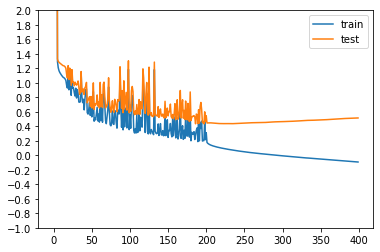

In [5]:
num_iters = 20000 # number of SGD steps
save_every = 100
initial_lr = 1e-5
lr = initial_lr
num_repeats = 2

state_vars = [tf.Variable(s) for s in initial_state]
opt = tf.optimizers.SGD(learning_rate=initial_lr)
def map_loss():
  return -bnn_joint_log_prob(*state_vars)
  
@tf.function
def minimize():
  opt.minimize(map_loss, state_vars)
  
# Traces is a list, one entry per weight/bias, of values
# obtained over the course of training
traces = [[] for _ in range(len(initial_state))]

for r in range(num_repeats):
  
  for i in range(num_iters):
    if i % save_every == 0:
      for t, s in zip(traces, state_vars):
        t.append(s.numpy())
    minimize()
    
  opt.learning_rate = 1e-2*opt.learning_rate
  
map_trace = [np.array(t) for t in traces]

# map_initial_state contains the same number of entries as initial_state
# note that this currently has 8 entries (one per weight matrix and bias)
# and each of those entries is a tensor, shapes given above
map_initial_state = [tf.constant(t[-1]) for t in map_trace]

# Graph training and test performance
plot_curves(map_trace)
plt.ylim(-1, 2)
plt.yticks(np.linspace(-1, 2, 16));

d = 0.0
for x in map_initial_state:
  d += tf.square(tf.norm(x))

print("Norm of MAP:")
tf.print(d)

# 3. Hamiltonian Monte Carlo from MAP

We have already trained the network by gradient descent to as close as possible to the critical locus of the loss function, now we start HMC from this stopping point of gradient descent, in three phases:

* **3.1 HMC:** run the Markov chain for some time
* **3.2 Find a candidate critical point**:
* **3.3 Sampling from the local posterior**

### 3.1 Run HMC

In [6]:
# The output chain has the following format: it is a list of eight lists
#
#  chain = [ c1, ..., c8 ]
#
# each list corresponds to one of the weight/bias matrices, as in map_initial_state
# and for 1 \le i \le 8 the list ci contains roughly num_leapfrog_steps*step_size
# elements, one for each sample. So if you take [ c1[-1], ..., c8[-1] ] you will
# obtain the final tensor, comparable in shape to map_initial_state

# NOTE: adaptation only changes step size, not number of leapfrog steps
PRE_HMC = False

if( PRE_HMC ):
  chain, trace, final_kernel_results = run_hmc(
    bnn_joint_log_prob,
    num_burnin_steps=2000, # was 10000
    num_leapfrog_steps=10,
    num_adaptation_steps=2000, # was 8000
    num_results=15000, # was 30000
    step_size=1e-6,
    current_state=map_initial_state)

  print("Acceptance rate:",
        trace.inner_results.is_accepted[-1000:].numpy().mean())

  for c in chain:
    print("ESS/step", tf.reduce_min(tfp.mcmc.effective_sample_size(c[-1000:]) / 1000).numpy())

  plt.figure()
  plt.title("Chains")
  for i in range(14):
    plt.plot(chain[6][:, i, 0])
  plt.show()

  plt.figure()
  plt.title("Step size")
  plt.plot(trace.inner_results.accepted_results.step_size)

  plt.figure()
  plt.title("Distances")
  plot_distances(chain, map_initial_state)
  plt.show()
  
  plot_curves([c[::50] for c in chain])
  plt.ylim(-1, 2)
  plt.yticks(np.linspace(-1, 2, 16));

### 3.2 Find our candidate critical point

We find a `chain_index` which picks out a position in the chain where the distance was stationary (see the graphs above)

In [7]:
if( PRE_HMC ):
  ball_radius = 2
  chain_index = -1 # default to last chain position
  num_samples = len(chain[0])

  # pos ranges over 0,100,200,...,num_samples
  for pos in range(num_samples)[::200]:
    acc_rate = trace.inner_results.is_accepted[pos:pos+100].numpy().mean()
  
    #print("Acceptance rate: " + str(acc_rate) + " at pos " + str(pos))
    if( acc_rate < 0.01 ):
      chain_index = pos

  if( chain_index == -1 ):
    print("Failed to find fixed point")
  else:
    print("Fixed point located: " + str(chain_index))
  
  # Take as the center of our neighborhood the weight value at this approximate
  # fixed point of the HMC in the above search
  center = [tf.constant(t[chain_index]) for t in chain]
else:
  center = map_initial_state

### 3.3 Estimate the local posterior around our candidate critical point

Here we modify the log probability to drop off to zero very quickly outside a ball of radius epsilon of the current weight vector found at the end of the last HMC round.

Acceptance rate: 0.789
ESS/step 0.027862957
ESS/step 0.074458845
ESS/step 0.03853114
ESS/step 0.08455863
ESS/step 0.049796443
ESS/step 0.08446881
ESS/step 0.112704985
ESS/step 0.12288371


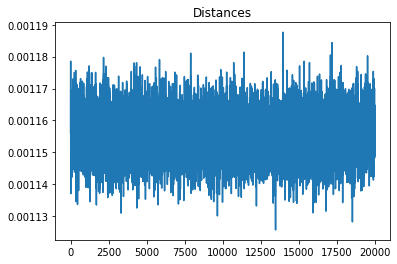

In [8]:
prior = "local" # global, local
local_weight_prior = tfd.Normal(0.0, 1e-5) # mean, std
local_bias_prior = tfd.Normal(0.0, 1e-5)

def bnn_joint_log_prob_fn_local(center, weight_prior, bias_prior, X, y, *args):
    weights_list = args[::2] # every second argument starting with 0
    biases_list = args[1::2] # every second argument starting with 1
    center_weights = center[::2]
    center_biases = center[1::2]
  
    lp = 0.0
    
    # prior log-prob
    if( prior == "global" ):
      lp = sum(
          [tf.reduce_sum(weight_prior.log_prob(weights)) for weights in weights_list]
      )
      lp += sum([tf.reduce_sum(bias_prior.log_prob(bias)) for bias in biases_list])
    else:
      lp = sum(
          [tf.reduce_sum(local_weight_prior.log_prob(w-cw)) 
           for (w,cw) in zip(weights_list,center_weights)]
      )
      lp += sum([tf.reduce_sum(local_bias_prior.log_prob(b-bw)) 
            for (b,bw) in zip(biases_list,center_biases)])
    
    # likelihood of predicted labels
    network = build_network(weights_list, biases_list)
    labels_dist = network(X.astype("float32"))
    lp += tf.reduce_sum(labels_dist.log_prob(y))
    
    # we also need to add a term that concentrates probability mass
    # in a ball around the MAP
    #d = 0.0
    
    #for (x, xprime) in zip(center, args):
    #  d += tf.square(tf.norm(x - xprime))
    
    #d = tf.sqrt(d)
    
    #lp += tf.cond( d > ball_radius, lambda: -10.0, lambda: 0.0 )
      
    #print("-")
    #tf.print(d)
    #tf.print(lp)
    
    return lp

bnn_joint_log_prob_local = partial(
    bnn_joint_log_prob_fn_local, center, weight_prior, bias_prior, X_train, y_train[:, 0]
)

fine_chain, fine_trace, fine_final_kernel_results = run_hmc(
    bnn_joint_log_prob_local,
    num_burnin_steps=10000,
    num_leapfrog_steps=5,
    num_adaptation_steps=8000,
    num_results=10000,
    step_size=1e-6,
    current_state=center)

print("Acceptance rate:",
        fine_trace.inner_results.is_accepted[-1000:].numpy().mean())

for c in fine_chain:
  print("ESS/step", tf.reduce_min(tfp.mcmc.effective_sample_size(c[-1000:]) / 1000).numpy())

plt.figure()
plt.title("Distances")
plot_distances(fine_chain, center)
plt.show()

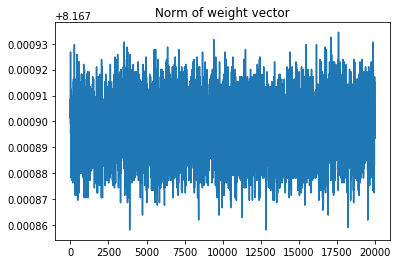

In [9]:
# NOTES
#
# Our weight and bias prior are quite strong given the norms involved, 

plt.figure()
plt.title("Norm of weight vector")
plot_distances(fine_chain, [0.0*x for x in center])
plt.show()

In [10]:
# Old

# NOTE: of course you will not find a long chain of "zero accept"
# if you adaptation! It will lower the learning rate until acceptances
# go back up

# TODO: we should just search in the chain of the previous step, not do this again!

# Restart chains with a lower learning rate
#resume = [chain, trace, final_kernel_results]

#hunt_count = 0
#max_hunt_count = 30
#accept_rate = 1.0

#while( accept_rate > 0.1 and hunt_count < max_hunt_count ):
#  hunt_count += 1
#  print("In hunt:" + str(hunt_count))
  
#  chain, trace, final_kernel_results = run_hmc(
#    bnn_joint_log_prob, # was bnn_joint_log_prob_local,
#    num_burnin_steps=0,
#    num_leapfrog_steps=10,
#    num_adaptation_steps=0,
#    num_results=500,
#    step_size=1e-5,
#    resume=resume)

#  accept_rate = trace.inner_results.is_accepted[-500:].numpy().mean()
#  print("Acceptance rate:", accept_rate)
    
#for c in chain:
#  print("ESS/step", tf.reduce_min(tfp.mcmc.effective_sample_size(c[-1000:]) / 1000).numpy())

#plt.figure()
#plt.title("Distances")
#plot_distances(chain, map_initial_state)
#plt.show()